Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
58889256/58889256 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 


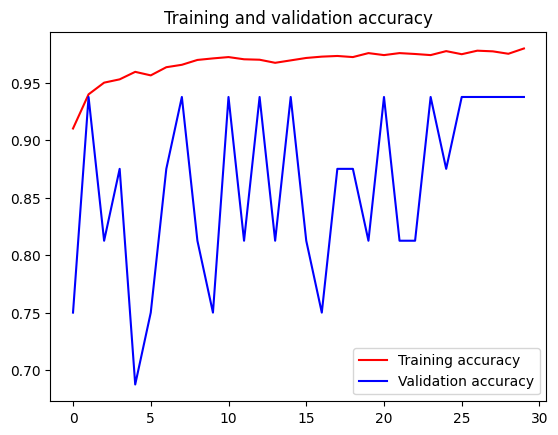

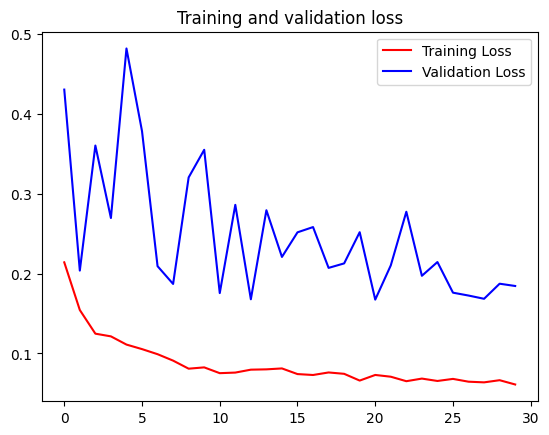

20/20 [==============================] - 7s 336ms/step - loss: 0.3228 - accuracy: 0.9087
Test accuracy: 0.9086538553237915


In [1]:
import os
import zipfile
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define paths
zip_file_path = '/content/drive/My Drive/cv_medical_model.zip'
extraction_path = '/content/cv_medical_model'

# Unzip the dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Directory setup
base_dir = os.path.join(extraction_path, 'chest_xray')
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Image data generators with data augmentation for the training set
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

# Validation and test data generators (no data augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(train_dir, batch_size=32, class_mode='binary', target_size=(224, 224))
val_generator = val_test_datagen.flow_from_directory(val_dir, batch_size=32, class_mode='binary', target_size=(224, 224))
test_generator = val_test_datagen.flow_from_directory(test_dir, batch_size=32, class_mode='binary', target_size=(224, 224))

# Model building
# Use a pre-trained VGG16 model, include_top is set to False to exclude the top layers
# Referenced from https://pubmed.ncbi.nlm.nih.gov/37938631/
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of VGG16
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))  # For binary classification

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

# Print model summary
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5)

# Train the model
history = model.fit(train_generator,
                    epochs=30,
                    validation_data=val_generator,
                    callbacks=[early_stopping, reduce_lr])

# Plotting training and validation accuracy/loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print('Test accuracy:', test_accuracy)